In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as UtiData
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import cv2
import numpy as np

import os, csv, argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from fcn32s import *
from fcn8s import *
from utils import *
from mean_iou_evaluate import *
from dataset import *
from criterion import *

In [ ]:
VGG16_net = torchvision.models.vgg16()
VGG16_net.load_state_dict(torch.load('vgg16-new.pth'))

In [5]:
net = FCN32s(7)
print(net)

FCN32s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dila

In [8]:
net = FCN8s(7)
#print(net)
print(net.named_children)

<bound method Module.named_children of FCN8s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(k

In [9]:
masks = read_masks('dataset/train')

In [25]:
mask_weight = []
for i in range(7):
    mask_weight.append(np.sum(masks>-1)/np.sum(masks == i))

In [46]:
cc = np.asarray(mask_weight)[0:6]/np.asarray(mask_weight)[0:6].sum()
cc/cc.max()
#(1/np.asarray(mask_weight))[1]/np.sum((1/np.asarray(mask_weight)))

array([0.29873678, 0.0560519 , 0.38079318, 0.2786428 , 1.        ,
       0.40306586])

In [46]:
n_class = 7
batch_size = 10
MAX_EPOCHS = 1
cuda_device = 0
down_scale = 1

torch.cuda.manual_seed(1337)
        
#net = VGG16_FCN32s(n_class)
#net.copy_vgg16(VGG16_net)
net = FCN32s(n_class)
#net.copy_params_from_vgg16(VGG16_net)
net.cuda()
#net = torch.nn.DataParallel(net).cuda()

filepath = 'dataset/train'
train_loader = get_data_loader(filepath, batch_size, down_scale)
loss_dir = 'FCN32s_Loss'
model_dir = 'FCN32s_Model'
if not os.path.exists(loss_dir):
    os.makedirs(loss_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
criterion = CrossEntropyLoss2d().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
loss_total = []
for ep in range(0, MAX_EPOCHS):
    epoch_loss = 0
    for it, (images, labels) in enumerate(train_loader):
        assert images.size(0) == labels.size(0)
        images = Variable(images.cuda()).cuda()
        labels = Variable(labels.cuda()).cuda()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        lbl_pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        lbl_true = labels.data.cpu().numpy()
        #_, pred = torch.max(output.data, 1)
        #acc = torch_mean_iou(lbl_pred, lbl_true)
        acc = np.sum(lbl_pred.flatten()==lbl_true.flatten())/len(lbl_true.flatten())
        print('epoch: {:3}, it: {:4}, loss: {:10.2f}, acc: {:10.2f}'.format(ep, it, loss.data[0], acc))
        epoch_loss += loss.data[0]
        loss_total.append(loss.data[0])
    print(epoch_loss/len(train_loader))
    for id in range(output.shape[0]):
        plt.figure(num=1, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(labels2im(output.data.max(1)[1].cpu().numpy()[id, :, :]))
        plt.figure(num=2, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        imc = images.data.cpu().numpy()[id,:,:,:]
        imc = imc.transpose((1,2,0))
        r = imc[:,:,0]
        g = imc[:,:,1]
        b = imc[:,:,2]
        imc[:,:,0] = (r - r.min())/(r.max() - r.min())
        imc[:,:,1] = (g - g.min())/(g.max() - g.min())
        imc[:,:,2] = (b - b.min())/(b.max() - b.min())
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(imc)
        plt.figure(num=3, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(labels2im(labels.data.cpu().numpy()[id,:,:]))
    #loss_file_name = os.path.join(loss_dir, '{:04d}.data' % ep)
    #loss_df = pd.DataFrame({"loss" : loss_total})
    #loss_df.to_csv(loss_file_name, index=False)
    
    #model_file_name = os.path.join(model_dir, '{:04d}.data' % ep)
    #torch.save(net.state_dict(), model_file_name)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as UtiData
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import cv2
import numpy as np

import os, csv, argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from fcn32s import VGG16_FCN32s
from model_test import *
from utils import *
from mean_iou_evaluate import *
from dataset import *
from criterion import *

n_class = 7
batch_size = 5
MAX_EPOCHS = 1
cuda_device = 0
down_scale = 1

filepath = 'dataset/validation'
train_loader = get_data_loader(filepath, batch_size, down_scale)
model_name = 'FCN32s'
model_id = 4
ep = 39
net = FCN32s(n_class)
net.load_state_dict(torch.load('{}{:02d}_Model/ep{:04d}_model.pkl'.format(model_name, model_id, ep)))
net.cuda()

criterion = CrossEntropyLoss2d().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

total_acc = 0
for it, (images, labels) in enumerate(train_loader):    
        assert images.size(0) == labels.size(0)
        images = Variable(images.cuda()).cuda()
        labels = Variable(labels.cuda()).cuda()
        output = net(images)
        lbl_pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        lbl_true = labels.data.cpu().numpy()
        #acc = mean_iou_score(lbl_pred, lbl_true)
        acc = np.sum(lbl_pred.flatten()==lbl_true.flatten())/len(lbl_true.flatten())
        total_acc += acc
        print(acc)
        if it > 200:
            break
print('total %f' % (total_acc/it))

0.8820220947265625
0.7568199157714843
0.7239334106445312
0.9552146911621093
0.9454826354980469
0.9071975708007812
0.8898666381835938
0.8221115112304688
0.8800910949707031
0.9015594482421875
0.7651809692382813
0.9505142211914063
0.9216949462890625
0.9124839782714844
0.9065605163574219
0.837066650390625
0.822265625
0.7528732299804688
0.9575088500976563
0.8731918334960938
0.7275177001953125
0.864422607421875
0.8534431457519531
0.8439773559570313
0.9321281433105468
0.8770545959472656
0.8414695739746094
0.8809364318847657
0.7573715209960937
0.9153526306152344
0.8903633117675781
0.8555389404296875
0.8424880981445313
0.8846183776855469
0.8295249938964844
0.8568466186523438
0.9420166015625
0.8554367065429688
0.9488632202148437
0.8648582458496094
0.9158966064453125
0.9151954650878906
0.9031852722167969
0.9203483581542968
0.8581245422363282
0.8461097717285156
0.89521484375
0.8558685302734375
0.8764137268066406
0.8119163513183594
0.8487594604492188
0.9389991760253906
total 0.886547


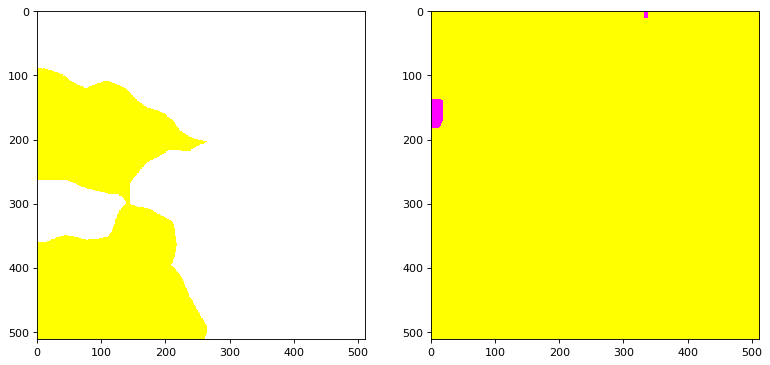

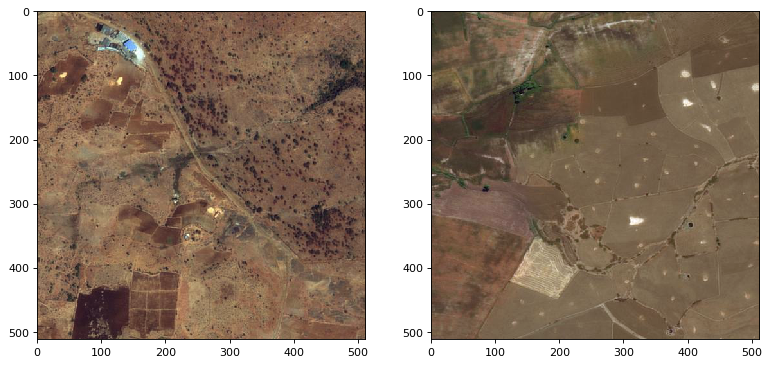

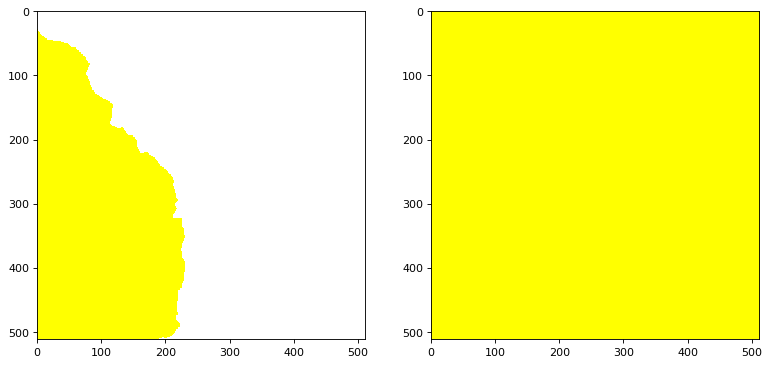

In [5]:
for id in range(output.shape[0]):
        plt.figure(num=1, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(labels2im(output.data.max(1)[1].cpu().numpy()[id, :, :]))
        plt.figure(num=2, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        imc = images.data.cpu().numpy()[id,:,:,:]
        imc = imc.transpose((1,2,0))
        imc = imc[:,:,::-1]
        r = imc[:,:,0]
        g = imc[:,:,1]
        b = imc[:,:,2]
        imc[:,:,0] = (r - r.min())/(r.max() - r.min())
        imc[:,:,1] = (g - g.min())/(g.max() - g.min())
        imc[:,:,2] = (b - b.min())/(b.max() - b.min())
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(imc)
        plt.figure(num=3, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1,output.shape[0]+1,id+1)
        plt.imshow(labels2im(labels.data.cpu().numpy()[id,:,:]))
        lbl_name = 'test_lbl/{:04d}_mask.png'.format(id)
        val_name = 'test_val/{:04d}_sat.jpg'.format(id)
        #cv2.imwrite(lbl_name,labels2im(output.data.max(1)[1].cpu().numpy()[id, :, :]))
        #cv2.imwrite(val_name,labels2im(labels.data.cpu().numpy()[id,:,:]))

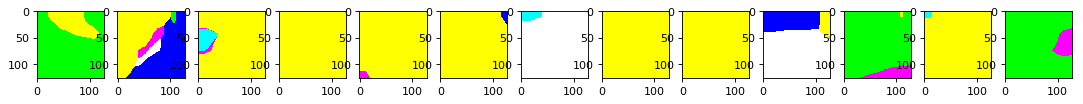

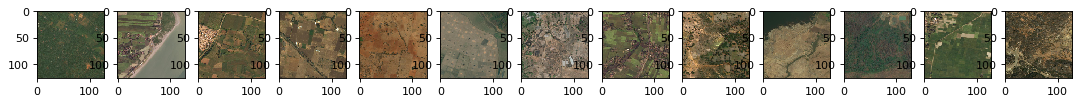

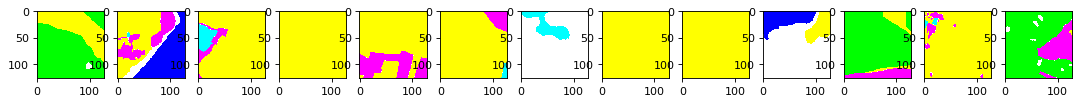

In [8]:
for id in range(output.shape[0]):
    plt.figure(num=1, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,output.shape[0]+1,id+1)
    plt.imshow(labels2im(output.data.max(1)[1].cpu().numpy()[id, :, :]))
    
    plt.figure(num=2, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    imc = images.data.cpu().numpy()[id,:,:,:]
    imc = imc.transpose((1,2,0))
    #r = imc[:,:,0]
    #g = imc[:,:,1]
    #b = imc[:,:,2]
    #imc[:,:,0] = (r - r.min())/(r.max() - r.min())
    #imc[:,:,1] = (g - g.min())/(g.max() - g.min())
    #imc[:,:,2] = (b - b.min())/(b.max() - b.min())
    imc = imc + VGG_mean
    imc = imc[:,:,::-1]
    plt.subplot(1,output.shape[0]+1,id+1)
    plt.imshow(np.uint8(imc))
    plt.figure(num=3, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,output.shape[0]+1,id+1)
    plt.imshow(labels2im(labels.data.cpu().numpy()[id,:,:]))

In [ ]:
id = 0

plt.figure(1)
imc = cv2.imread('dataset/train/{:04d}_sat.jpg'.format(id))
plt.subplot(1, 2, 1)
plt.imshow(imc)

plt.figure(1)
mask = cv2.imread('dataset/train/{:04d}_mask.png'.format(id))
mask = mask[:,:,::-1] # RGB
plt.subplot(1, 2, 2)
plt.imshow(mask)

ctt = t_dataset_sat_image('dataset/train').__getitem__(id)

plt.figure(2)
imc = ctt[0]
imc = imc.numpy()
imc = imc.transpose((1,2,0))
r = imc[:,:,0]
g = imc[:,:,1]
b = imc[:,:,2]
imc[:,:,0] = (r - r.min())/(r.max() - r.min())
imc[:,:,1] = (g - g.min())/(g.max() - g.min())
imc[:,:,2] = (b - b.min())/(b.max() - b.min())
plt.subplot(1, 2, 1)
plt.imshow(imc)

plt.figure(2)
mask = ctt[1]
mask = mask.numpy()
plt.subplot(1, 2, 2)
plt.imshow(labels2im(mask))

In [29]:
net.conv6.weight.data.cpu()[0,0,:,:]


1.00000e-03 *
  0.0197  0.4535  0.5561  0.9152  1.4976  0.3651  1.4528
 -1.3801 -2.7488 -3.7093 -0.1644 -0.6775  0.4265  1.2458
 -1.1737  1.2341  0.0579 -1.6586 -1.3877  2.7608  3.1592
  0.6718 -0.4232  0.4327 -0.5365  1.2552  2.7452  2.9772
  4.6118  1.3631 -0.5234  0.2009  2.4166  3.7090  2.6557
  3.4331  2.7141  1.2838  0.3426  2.5551  2.2177  1.0179
  1.1445  2.9156  0.8114  1.4945  1.5716  1.6618  2.6698
[torch.FloatTensor of size 7x7]

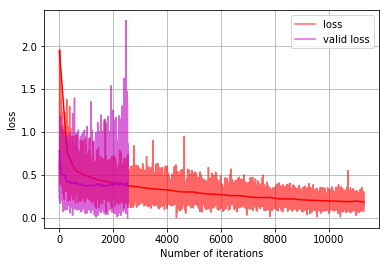

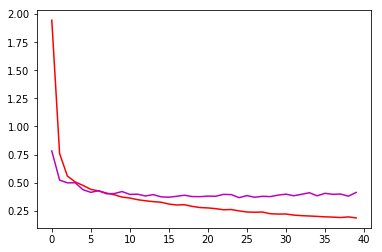

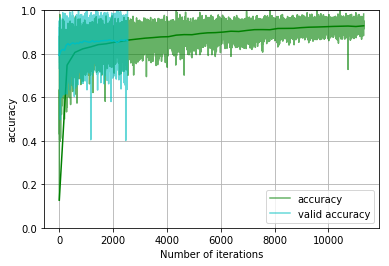

In [8]:
id = 38
model_id = 4

import numpy as np

import os, csv, argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

loss_read = pd.read_csv('FCN32s{:02d}_Loss/ep{:04d}_loss.data'.format(model_id, id))
data_len = int(len(loss_read['loss'])/(id+1))
x_ep = []
y_ep = []
yp_ep = []
x_ep.append(0)
y_ep.append(loss_read['loss'][0])
yp_ep.append(loss_read['acc'][0])

for i in range(id+1):
    x_ep.append(((i+1)*data_len-1)) 
    y_ep.append(np.sum(loss_read['loss'][i*data_len:((i+1)*data_len-1)])/data_len)
    yp_ep.append(np.sum(loss_read['acc'][i*data_len:((i+1)*data_len-1)])/data_len)
    
plt.figure
#plt.semilogy(loss_read['loss'], 'r')
#plt.semilogy(loss_read['acc'], 'g')
plt.figure(1)
plt.plot(loss_read['loss'], 'r', alpha=0.6, label='loss')
plt.plot(x_ep, y_ep, 'r')
plt.legend(loc=0)
plt.xlabel('Number of iterations')
plt.ylabel('loss')
plt.grid(True)    
plt.savefig('FCN32s{:02d}_Model/loss.jpg'.format(model_id), dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='jpg',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

plt.figure(3)
plt.plot(y_ep, 'r')

plt.figure(2)
plt.plot(loss_read['acc'], 'g', alpha=0.6, label='accuracy')
plt.plot(x_ep, yp_ep, 'g')
plt.legend(loc=0)
plt.ylim([0,1])
plt.xlabel('Number of iterations')
plt.ylabel('accuracy')
plt.grid(True)

loss_read = pd.read_csv('FCN32s{:02d}_Loss/ep{:04d}_valid_loss.data'.format(model_id, id))
data_len = int(len(loss_read['test_loss'])/(id+1))
x_ep = []
y_ep = []
yp_ep = []
x_ep.append(0)
y_ep.append(loss_read['test_loss'][0])
yp_ep.append(loss_read['test_acc'][0])

for i in range(id+1):
    x_ep.append(((i+1)*data_len-1)) 
    y_ep.append(np.sum(loss_read['test_loss'][i*data_len:((i+1)*data_len-1)])/data_len)
    yp_ep.append(np.sum(loss_read['test_acc'][i*data_len:((i+1)*data_len-1)])/data_len)
    
plt.figure
#plt.semilogy(loss_read['loss'], 'r')
#plt.semilogy(loss_read['acc'], 'g')
plt.figure(1)
plt.plot(loss_read['test_loss'], 'm', alpha=0.6, label='valid loss')
plt.plot(x_ep, y_ep, 'm')
plt.legend(loc=0)
plt.xlabel('Number of iterations')
plt.ylabel('loss')
plt.grid(True)    
plt.savefig('FCN32s{:02d}_Model/valid_loss.jpg'.format(model_id), dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='jpg',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
plt.figure(3)
plt.plot(y_ep, 'm')

plt.figure(2)
plt.plot(loss_read['test_acc'], 'c', alpha=0.6, label='valid accuracy')
plt.plot(x_ep, yp_ep, 'c')
plt.legend(loc=0)
plt.ylim([0,1])
plt.xlabel('Number of iterations')
plt.ylabel('accuracy')
plt.grid(True)

plt.savefig('FCN32s{:02d}_Model/valid_accuracy.jpg'.format(model_id), dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='jpg',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
#plt.savefig(folder+'hw1_1_1_loss'+str(num_func)+'.jpg', dpi=600, facecolor='w', edgecolor='w',
#                orientation='portrait', papertype=None, format='jpg',
#                transparent=False, bbox_inches=None, pad_inches=0.1,
 #               frameon=None)

In [1]:
x = loss_read['loss'].data
print(x)

NameError: name 'loss_read' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as UtiData
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import cv2
import numpy as np

import os, csv, argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from fcn32s import VGG16_FCN32s
from model_test import *
from utils import *
from mean_iou_evaluate import *
from dataset import *
from criterion import *

n_class = 7
batch_size = 10
MAX_EPOCHS = 1
cuda_device = 0
down_scale = 1

net = FCN32s(n_class)
model_name = 'FCN32s'
model_id = 1
ep = 99
net = FCN32s(n_class)
net.load_state_dict(torch.load('{}{:02d}_Model/ep{:04d}_model.pkl'.format(model_name, model_id, ep)))
net.cuda()

filepath = 'dataset/validation/'
im_list = [os.path.join(filepath, file) 
                   for file in os.listdir(filepath) if file.endswith('.jpg')]
im_list.sort()

val_save_dir = model_name + '{:02d}_ep{:04d}_Val'.format(model_id, ep)
if not os.path.exists(val_save_dir):
    os.makedirs(val_save_dir)

totol_acc = 0
for im_name in im_list:
        img_test, lbl_test = dataset_sat_image(filepath)._load_one_image(im_name, 
                                                                         test=True)
        img_test = np.float64(img_test)
        img_test -= VGG_mean
        img_CxHxW = img_test.transpose((2, 0, 1))  # convert to CHW
        img_test = ((torch.FloatTensor(img_CxHxW)))
        lbl_test = ((torch.LongTensor(lbl_test)))
        img_test_final = img_test.contiguous()
        lbl_test_final = lbl_test.contiguous()
        img_test_final = Variable(img_test_final.view(1,
                                                      img_test_final.size(0),
                                                      img_test_final.size(1),
                                                      img_test_final.size(2))).cuda()
        lbl_test_final = Variable(lbl_test_final.view(1,
                                                      lbl_test_final.size(0),
                                                      lbl_test_final.size(1))).cuda()
        output = net(img_test_final)
        lbl_pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        lbl_true = lbl_test_final.data.cpu().numpy()
        acc = np.sum(lbl_pred.flatten()==lbl_true.flatten())/len(lbl_true.flatten())
        print(acc)
        totol_acc += acc
        label_im = labels2im(output.data.max(1)[1].cpu().numpy().squeeze())
        im_save_name = os.path.join(val_save_dir, im_name[-12:-8]+'_mask.png')
        #print(im_save_name)
        cv2.imwrite(im_save_name, label_im[:,:,::-1])
print(totol_acc/len(im_list))

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt
imv = cv2.imread('dataset/validation/0000_sat.jpg')
lbl = cv2.imread('dataset/validation/0000_mask.png')
print(np.random.randint(1))
plt.figure(1)
plt.imshow(imv)
plt.figure(2)
plt.imshow(lbl)

axis = int(np.round(np.random.rand(1)))
plt.figure(3)
plt.imshow(np.flip(imv, axis=axis))
plt.figure(4)
plt.imshow(np.flip(lbl, axis=axis))

0

In [45]:
import torch
from torch.utils.model_zoo import load_url
from torchvision import models

#sd = load_url("https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg19-d01eb7cb.pth")
sd = torch.load('vgg16-caffe.pth')
sd['classifier.0.weight'] = sd['classifier.1.weight']
sd['classifier.0.bias'] = sd['classifier.1.bias']
del sd['classifier.1.weight']
del sd['classifier.1.bias']

sd['classifier.3.weight'] = sd['classifier.4.weight']
sd['classifier.3.bias'] = sd['classifier.4.bias']
del sd['classifier.4.weight']
del sd['classifier.4.bias']

torch.save(sd, "vgg19-d01eb7cb.pth")

In [6]:
import os
model_name = 'FCN32s'
model_id = 2
for ep in range(100):
    if not ((ep+1) % 5 == 0 or ep ==0):
        os.remove('{}{:02d}_Model/ep{:04d}_model.pkl'.format(model_name, model_id, ep))